In [1]:
import os
# 設置環境變數
os.environ["LOKY_MAX_CPU_COUNT"] = "2"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Problem : Principal Component Analysis
**Principal component analysis** (PCA) is a technique of dimensionality reduction, which linearly maps data onto a lower-dimensional space, so that the variance of the projected data in the associated dimensions would be maximized. In this problem, you will perform PCA on a dataset of face images.

Principal Component Analysis (PCA): 主成分分析是一種降維技術，它將數據映射到較低維度的空間，以最大化相關聯維度中投影數據的方差

您將對一組人臉圖像數據集進行PCA分析。
- 資料夾`data`包含40個不同主體(類別)的人臉圖像，每個主體有10個灰度圖像，圖像尺寸均為(56, 46)像素
- 請注意，`i_j.png`是第 i 個人、第 j 個圖像，為了簡化，我們用 `person_i_image_j` 表示

首先，將數據集分成兩個子集(即訓練集和測試集)
- 第一個子集包含每個主體的前9張圖像
- 而第二個子集包含剩餘的圖像。
- 這樣就有 9 × 40 = 360 張圖像在訓練集中，1 × 40 = 40 張圖像在測試集中

在這個問題中，您將計算訓練集的特徵臉，並將測試集中圖像投影到相同的特徵空間中，以達到降維的目的

In [3]:
# 初始化空的列表來儲存訓練集和測試集資料
X_train, X_test = [], []
Y_train, Y_test = [], []

# 讀取圖像並分別存入訓練集和測試集
for i in range(1, 41):  # 40個人
    for j in range(1, 10):  # 每個人的前9張圖像作為訓練集
        img = cv2.imread(f'./data/{i}_{j}.png', cv2.IMREAD_GRAYSCALE)
        X_train.append(img)
        Y_train.append(i)
    # 每個人的第10張圖像作為測試集
    img = cv2.imread(f'./data/{i}_10.png', cv2.IMREAD_GRAYSCALE)
    X_test.append(img)
    Y_test.append(i)

# 將列表轉換為NumPy陣列
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# 打印資料集形狀
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(360, 56, 46) (360,)
(40, 56, 46) (40,)


## 1. mean face & first four eigenfaces

在訓練集上進行PCA，繪製均值臉和前四個特徵臉。

X_train.shape: (360, 56, 46)
X_train.reshape: (360, 2576)
pca.mean_: (2576,)
pca.mean_.reshape: (56, 46)
pca.components_[0]: (2576,)
pca.components_[0].reshape: (56, 46)


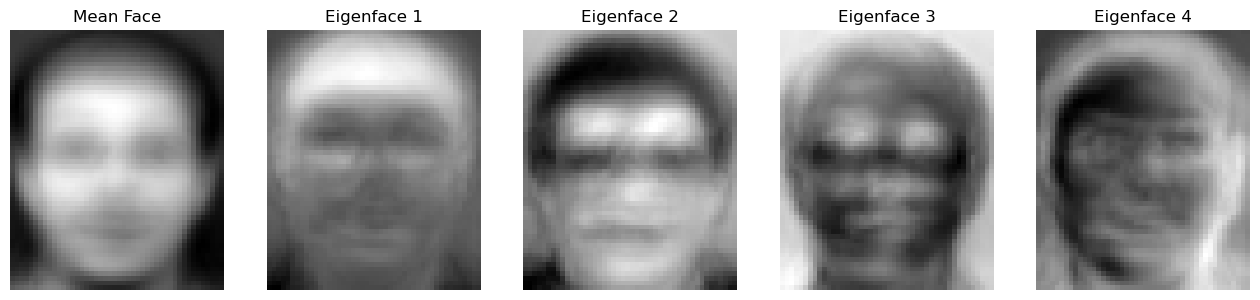

In [4]:
# 1. Perform PCA on the training set
# 使用PCA進行特徵提取
pca = PCA()
# 將訓練集進行展平(每個圖像從2D展平成1D)
X_train_flat = X_train.reshape(len(Y_train), -1)
print(f'X_train.shape: {X_train.shape}')
print(f'X_train.reshape: {(X_train.reshape(len(Y_train), -1)).shape}')
pca.fit(X_train_flat)

# 繪製mean face和前四個特徵臉
plt.figure(figsize=(16, 12))

# 繪製mean face
plt.subplot(1, 5, 1)
plt.axis('off')
plt.title('Mean Face')
print(f'pca.mean_: {(pca.mean_).shape}')
print(f'pca.mean_.reshape: {(pca.mean_.reshape(X_train[0].shape)).shape}')
plt.imshow(pca.mean_.reshape(X_train[0].shape), cmap='gray')

# 繪製前四個特徵臉
for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.axis('off')
    plt.title(f'Eigenface {i+1}')
    plt.imshow(pca.components_[i].reshape(X_train[0].shape), cmap='gray')

print(f'pca.components_[0]: {(pca.components_[0]).shape}')    
print(f'pca.components_[0].reshape: {(pca.components_[0].reshape(X_train[0].shape).shape)}')

plt.show()

## 2. Reconstruct person2 image1 using the first n = 3, 50, 170, 240, 345 eigenfaces
## 3. compute the mean squared error

取 person2_image1，將其投射到1中獲得的PCA特徵空間中。使用前 n = 3, 50, 170, 240, 345 個特徵臉重構這個圖像。

繪製這四個重構的圖像，並計算重構圖像和原始圖像之間的均方誤差(MSE)。

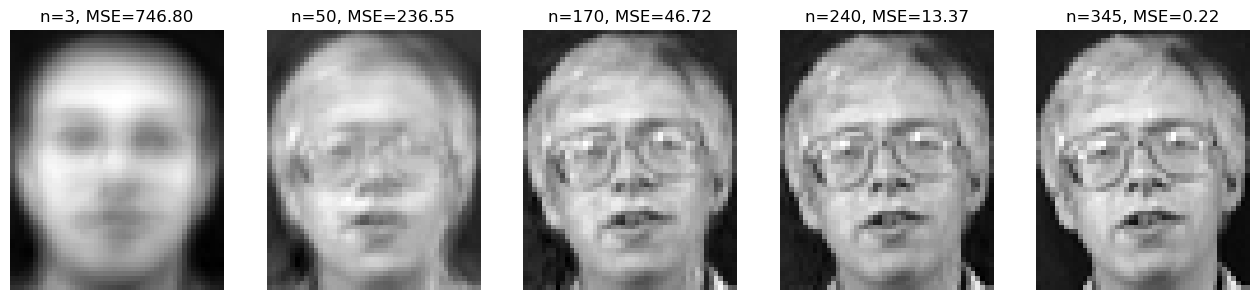

In [5]:
# 2. Reconstruct person2_image1 using different numbers of eigenfaces
original_image = cv2.imread('data/2_1.png', cv2.IMREAD_GRAYSCALE).reshape(1, -1)
projected_image = pca.transform(original_image)

plt.figure(figsize=(16,12))
n_components = [3, 50, 170, 240, 345]

for i, n in enumerate(n_components):
    reconstructed_face = np.zeros(original_image.shape)
    for j in range(n):
        reconstructed_face = reconstructed_face + projected_image[0][j]*pca.components_[j]
    reconstructed_face = reconstructed_face + pca.mean_

    MSE = np.mean((reconstructed_face-original_image)**2)
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title("n={}, MSE={:.2f}".format(n, MSE))
    plt.imshow(reconstructed_face.reshape(X_train[0].shape), cmap='gray')

## 4. cross-validation results

用knn對測試集圖像進行分類。
- 需要透過3-fold交叉驗證來確定最佳的 k 和 n 值。
- 簡單起見，這裡的超參數選擇為 k = {1, 3, 5} 和 n = {3, 50, 170}。
- 顯示交叉驗證結果並解釋您為 (k, n) 選擇的原因

In [6]:
# 初始化PCA並在訓練資料上擬合模型
pca = PCA()
pca.fit(X_train.reshape(len(Y_train), -1))

# PCA降維
X_train_pca = pca.transform(X_train.reshape(len(Y_train), -1))

# 設定超參數
k_values = [1, 3, 5]
n_components_list = [3, 50, 170]

# 隨機排列訓練資料
shuffled_indices = np.random.permutation(len(Y_train))
X_train_pca = X_train_pca[shuffled_indices]
Y_train_shuffled = Y_train[shuffled_indices]

# KNN交叉驗證
for k in k_values:
    print("k={}".format(k))
    knn = KNeighborsClassifier(n_neighbors=k)
    for n in n_components_list:
        print('    n={}, '.format(n), end='')
        score = cross_val_score(knn, X_train_pca[:, :n], Y_train_shuffled, cv=3)
        print('score={:.4f}'.format(score.mean()))

k=1
    n=3, score=0.7167
    n=50, score=0.9694
    n=170, score=0.9639
k=3
    n=3, score=0.6333
    n=50, score=0.9278
    n=170, score=0.9278
k=5
    n=3, score=0.5500
    n=50, score=0.8806
    n=170, score=0.8639


## 5. recognition rate of the testing set

使用您在4中選擇的超參數，並報告測試集的辨別率(recognition rate)。

In [7]:
# 設定超參數
k = 1
n = 50

# 初始化PCA並在訓練資料上擬合模型
pca = PCA()
pca.fit(X_train.reshape(len(Y_train), -1))

# PCA 降維(應用於訓練集和測試集)
X_train_pca = pca.transform(X_train.reshape(len(Y_train), -1))
X_test_pca = pca.transform(X_test.reshape(len(Y_test), -1))

# 隨機排列訓練資料
shuffled_indices = np.random.permutation(len(Y_train))
X_train_pca = X_train_pca[shuffled_indices]
Y_train_shuffled = Y_train[shuffled_indices]

# 初始化KNN分類器
knn = KNeighborsClassifier(n_neighbors=k)

# 使用訓練集進行模型訓練
knn.fit(X_train_pca[:, :n], Y_train_shuffled)

# 計算並輸出在測試集上的準確度
accuracy = knn.score(X_test_pca[:, :n], Y_test)
print(f'Accuracy = {accuracy:.4f}')

Accuracy = 0.9250
